In [11]:
import pandas as pd
import numpy as np
import seaborn as sns 
import os
import re

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

from matplotlib import cm


from langdetect import detect

In [2]:
sdg_names = pd.read_excel("Digital Science SDG training set searches.xlsx")
sdg_names = sdg_names.drop([0,1,2], axis=0)
sdg_names = sdg_names.set_axis(["sdg", "sdg_name", "sdg_definition"],axis=1, copy=False)
target_names = sdg_names.sdg_name.tolist()


In [3]:
import tensorflow as tf
import tensorflow_hub as hub

embed_url = "https://tfhub.dev/google/universal-sentence-encoder/4" # "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(embed_url) # print ("module %s loaded" % module_url)

2023-03-24 13:38:48.683390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import nltk.data
from nltk import word_tokenize, sent_tokenize
#tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [5]:
def get_text_df(file_name):
    text_df = pd.read_csv(file_name, sep = "\t", quotechar='"')
    col_names = text_df.columns.values[0].split('\t')
    text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
    text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
    text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
    text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
    text_df.reset_index(drop=True, inplace=True)
    return text_df

In [6]:
file_name = "/Users/yingli/Downloads/osdg-community-data-v2023-01-01.csv"
text_df = get_text_df(file_name)
text_df["embedding"] = list(embed(text_df.text))

2023-03-24 13:39:05.671802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


In [14]:
docs = text_df.embedding.tolist()
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

              precision    recall  f1-score   support

           1     0.7325    0.7401    0.7363       481
           2     0.7529    0.8291    0.7892       316
           3     0.9084    0.9125    0.9104       674
           4     0.8607    0.9525    0.9043       863
           5     0.8723    0.9359    0.9030       920
           6     0.8496    0.8624    0.8559       465
           7     0.8174    0.8767    0.8460       730
           8     0.6942    0.4759    0.5647       353
           9     0.7310    0.6463    0.6861       328
          10     0.7006    0.4297    0.5327       256
          11     0.7747    0.7965    0.7855       462
          12     0.8841    0.5622    0.6873       217
          13     0.7484    0.7923    0.7697       443
          14     0.8849    0.8479    0.8660       263
          15     0.8576    0.8083    0.8322       313
          16     0.9004    0.9499    0.9245      1057

    accuracy                         0.8313      8141
   macro avg     0.8106   

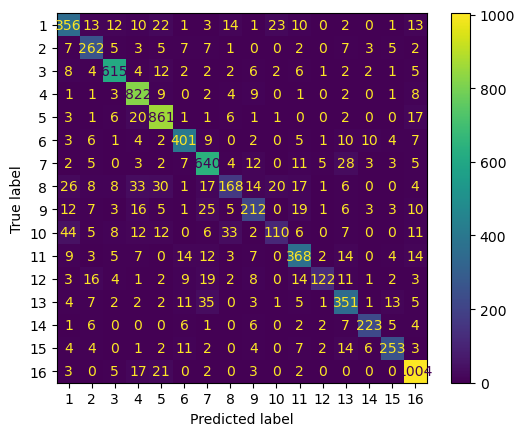

In [15]:
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
ridge_clf = ridge_clf.fit(X_train_scaled, y_train)
y_pred = ridge_clf.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [16]:
ridge_clf.decision_function(X_test_scaled).shape

(8141, 16)

In [17]:
docs = text_df.embedding.tolist()
categories = text_df.sdg

label_binarizer = LabelBinarizer().fit(categories) 
categories_onehot = label_binarizer.transform(categories)
n_classes = categories_onehot.shape[1]

X_train, X_test, y_train, y_test = train_test_split(docs, categories_onehot, test_size=.33, random_state=0)
ovr_mlp_clf = OneVsRestClassifier(MLPClassifier(random_state=0, max_iter=300)).fit(X_train,y_train)
y_score = ovr_mlp_clf.predict_proba(X_test)

#ovr_svm_clf = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=0))
#y_score = ovr_mlp_clf.fit(X_train, y_train).decision_function(X_test)



In [20]:
fpr[1].shape

(248,)

In [19]:
y_test.shape

(8141, 16)

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_40385/2581235148.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = list(cm.get_cmap('tab20').colors)


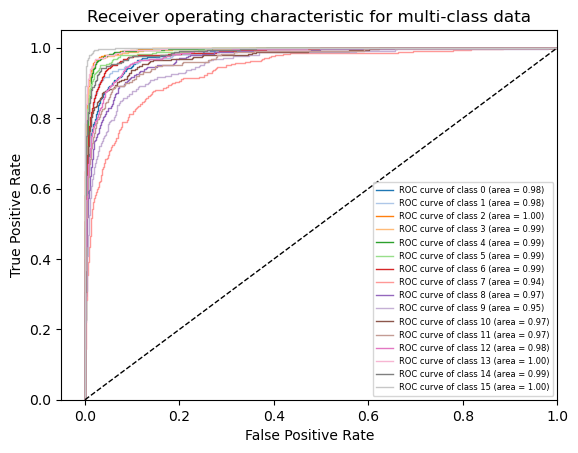

In [21]:
from matplotlib import cm
colors = list(cm.get_cmap('tab20').colors)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i]) # roc_curve works on binary
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,alpha = 1, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right", fontsize=6)
plt.show()

In [23]:
from sklearn.linear_model import LogisticRegression

docs = text_df.embedding.tolist()
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit_clf = LogisticRegression(tol=1e-2, solver="liblinear")
logit_clf = logit_clf.fit(X_train_scaled, y_train)
y_pred = logit_clf.predict(X_test_scaled)

# metrics.roc_auc_score work on binary and multiclass
metrics.roc_auc_score(y_test,logit_clf.predict_proba(X_test_scaled), multi_class='ovr')

0.9829408116968854

In [24]:
from sklearn.linear_model import LogisticRegression
ridge_clf = LogisticRegression(solver="liblinear")
ridge_clf = ridge_clf.fit(X_train_scaled, y_train)
y_pred = ridge_clf.predict(X_test_scaled)

metrics.roc_auc_score(y_test,ridge_clf.predict_proba(X_test_scaled), multi_class='ovr')

0.9826035399319409

In [25]:
label_binarizer = LabelBinarizer().fit(categories) # fit(y_train) may give incomplete list
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(8141, 16)

* transform a list of labels into a list of binary vector

In [26]:
label_binarizer.transform([5,10,5,8,9,8])

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

* reverse a binary label vector into orignal label 

In [27]:
label_binarizer.inverse_transform(np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

array([5])

In [28]:
class_of_interest = 5
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

4

In [29]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=1000)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)


/Users/yingli/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [140]:
y_score.shape

(8141, 16)

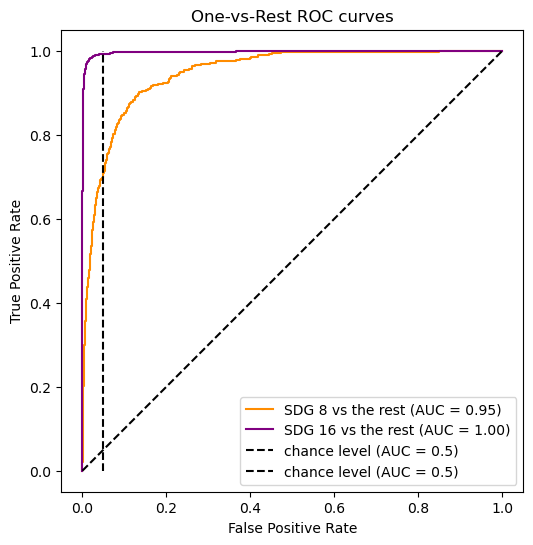

In [151]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6,6))

class_of_interest = 8
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"SDG {class_of_interest} vs the rest",
    color="darkorange",
    ax = ax,
)
class_of_interest = 16
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"SDG {class_of_interest} vs the rest",
    color="purple",
    ax = ax,
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.plot([0.05, 0.05], [0, 1], "k--", label="chance level (AUC = 0.5)")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()

In [91]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.98


In [92]:
n_classes = len(np.unique(categories))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.98


/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_31021/2978945377.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = list(cm.get_cmap('tab20').colors)


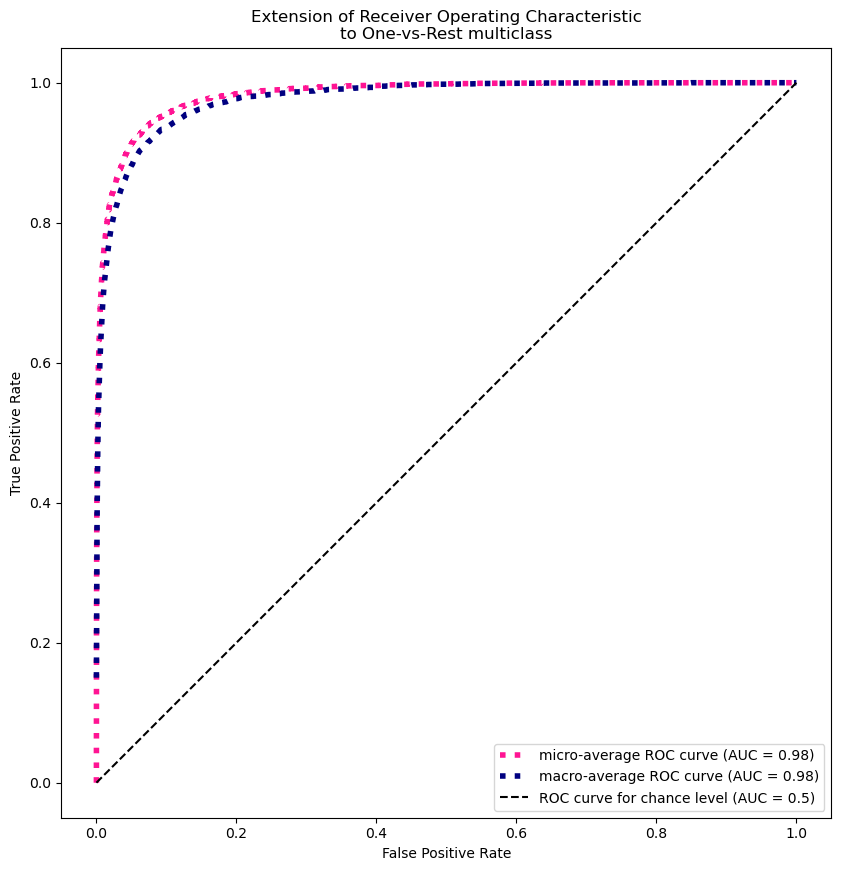

In [119]:
from matplotlib import cm
colors = list(cm.get_cmap('tab20').colors)

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_31021/3152823954.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = list(cm.get_cmap('tab20').colors)


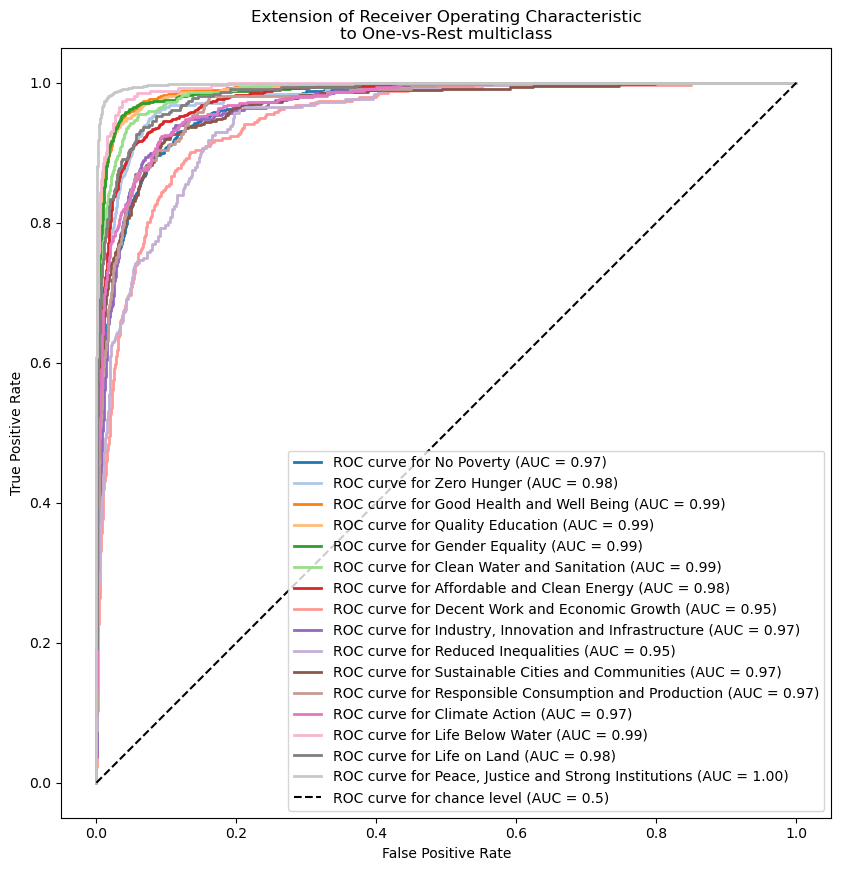

In [118]:
from matplotlib import cm
colors = list(cm.get_cmap('tab20').colors)

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)


for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        linewidth = 1,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [78]:
y_onehot_test[:10,]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])